In [1]:
import pandas as pd

logw_df= pd.read_csv('Submit/submission_xgb_logw_final.csv')
clip_df = pd.read_csv('Submit/submit_0822_clipped3.66.csv')
ensenble_df = pd.read_csv('Submit/submit0821_가중앙상블+클리핑3.3732.csv')

행 개수: 168
   num_date_time         logw       clip          ens
0  1_20240825 00  4916.669678  4377.2407  4505.021843
1  1_20240825 01  4728.371338  3872.5774  4357.705858
2  1_20240825 02  4610.544189  3681.8218  3993.383442
3  1_20240825 03  4328.175293  3282.3052  3459.373699
4  1_20240825 04  4166.913086  3008.5354  3291.703116

=== Pairwise 비교 (RMSE / SMAPE) ===
logw vs clip  |  RMSE=641.4413  |  SMAPE%=10.7755
logw vs ens  |  RMSE=292.4439  |  SMAPE%=4.5059
clip vs ens  |  RMSE=558.8363  |  SMAPE%=8.3358


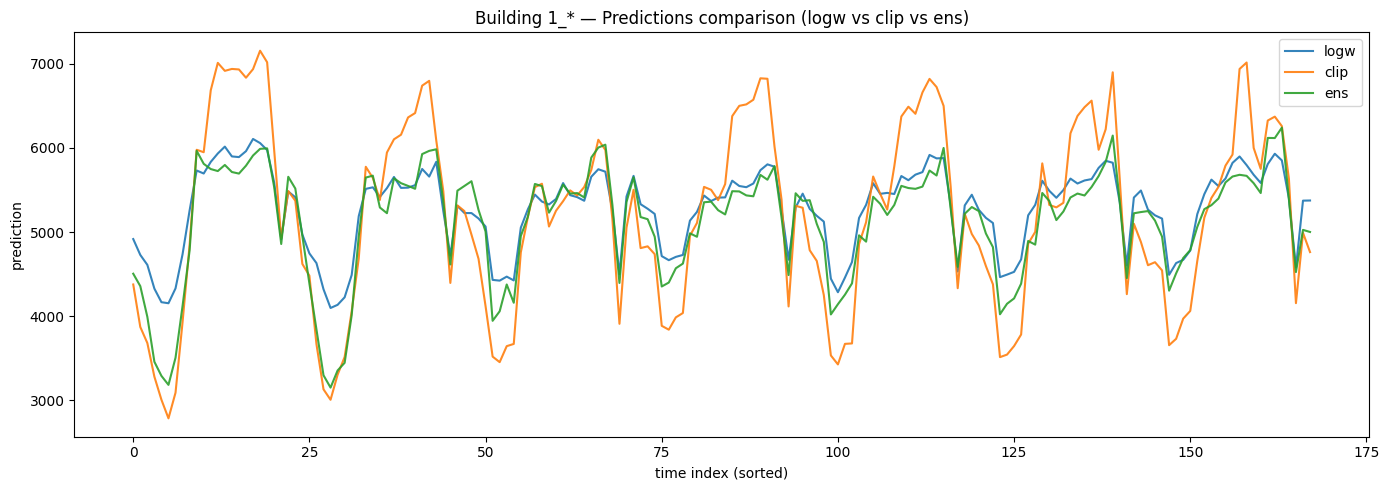

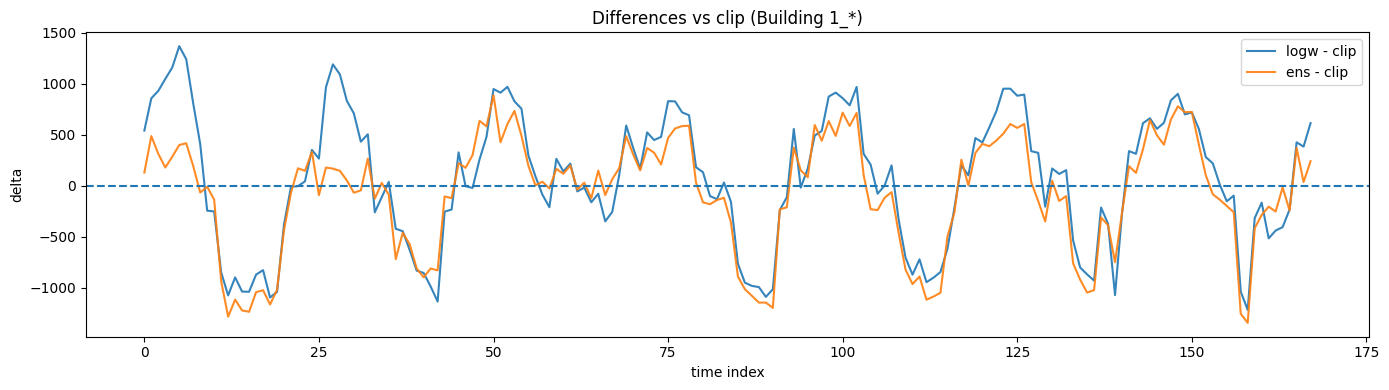

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 이미 읽어둔 df 사용: logw_df, clip_df, ensenble_df
# (없다면 pd.read_csv(...)로 읽어오면 됨)

def ensure_cols(df, name):
    df = df.copy()
    # 키/값 표준화
    if "num_date_time" not in df.columns:
        raise ValueError(f"{name}: num_date_time 컬럼이 필요합니다.")
    # 값 컬럼 찾기 (answer 또는 pred)
    val_col = None$
    for c in ["answer", "pred", "value", "prediction"]:
        if c in df.columns:
            val_col = c
            break
    if val_col is None:
        raise ValueError(f"{name}: 예측값 컬럼(answer/pred)이 없습니다.")
    df["num_date_time"] = df["num_date_time"].astype(str)
    df = df[["num_date_time", val_col]].rename(columns={val_col: name})
    return df

# 1) 컬럼 정리
logw   = ensure_cols(logw_df,   "logw")
clip   = ensure_cols(clip_df,   "clip")
ens    = ensure_cols(ensenble_df, "ens")

# 2) 건물번호 1_인 행만 필터
f = lambda d: d[d["num_date_time"].str.startswith("1_")]
logw1, clip1, ens1 = f(logw), f(clip), f(ens)

# 3) 키 기준 병합 (num_date_time)
m = logw1.merge(clip1, on="num_date_time", how="outer") \
         .merge(ens1,  on="num_date_time", how="outer")

# 4) 시간 정렬 (가능하면 뒤쪽 YYYYMMDD HH로 정렬)
try:
    m["_t"] = pd.to_datetime(m["num_date_time"].str.split("_").str[-1],
                             format="%Y%m%d %H", errors="coerce")
    m = m.sort_values("_t").drop(columns="_t")
except Exception:
    pass

# 5) 숫자화 & 기본 통계
for c in ["logw","clip","ens"]:
    m[c] = pd.to_numeric(m[c], errors="coerce")

print("행 개수:", len(m))
print(m.head())

# 6) 지표 함수
def rmse(a, b):
    mask = a.notna() & b.notna()
    if mask.sum() == 0: return np.nan
    return float(np.sqrt(((a[mask]-b[mask])**2).mean()))

def smape_pair(a, b, eps=1e-8):
    mask = a.notna() & b.notna()
    if mask.sum() == 0: return np.nan
    aa, bb = a[mask].values, b[mask].values
    return 100.0 * np.mean(2.0*np.abs(bb-aa)/(np.abs(aa)+np.abs(bb)+eps))

pairs = [("logw","clip"), ("logw","ens"), ("clip","ens")]
print("\n=== Pairwise 비교 (RMSE / SMAPE) ===")
for a,b in pairs:
    print(f"{a} vs {b}  |  RMSE={rmse(m[a], m[b]):.4f}  |  SMAPE%={smape_pair(m[a], m[b]):.4f}")

# 7) 라인플롯(시간 순): 세 모델 비교
plt.figure(figsize=(14,5))
for c in ["logw","clip","ens"]:
    if m[c].notna().any():
        plt.plot(m.index, m[c], label=c, alpha=0.9)
plt.title("Building 1_* — Predictions comparison (logw vs clip vs ens)")
plt.xlabel("time index (sorted)"); plt.ylabel("prediction")
plt.legend(); plt.tight_layout()
plt.show()

# 8) 차이(잔차) 플롯: 기준을 clip으로
if m["clip"].notna().any():
    plt.figure(figsize=(14,4))
    if m["logw"].notna().any():
        plt.plot(m.index, m["logw"]-m["clip"], label="logw - clip", alpha=0.9)
    if m["ens"].notna().any():
        plt.plot(m.index, m["ens"]-m["clip"],  label="ens - clip", alpha=0.9)
    plt.axhline(0, ls="--")
    plt.title("Differences vs clip (Building 1_*)")
    plt.xlabel("time index"); plt.ylabel("delta")
    plt.legend(); plt.tight_layout()
    plt.show()


저점 기준: 3475.5190049999997  | 고점 기준: 6908.3759
대체된 포인트 수: 18 / 168


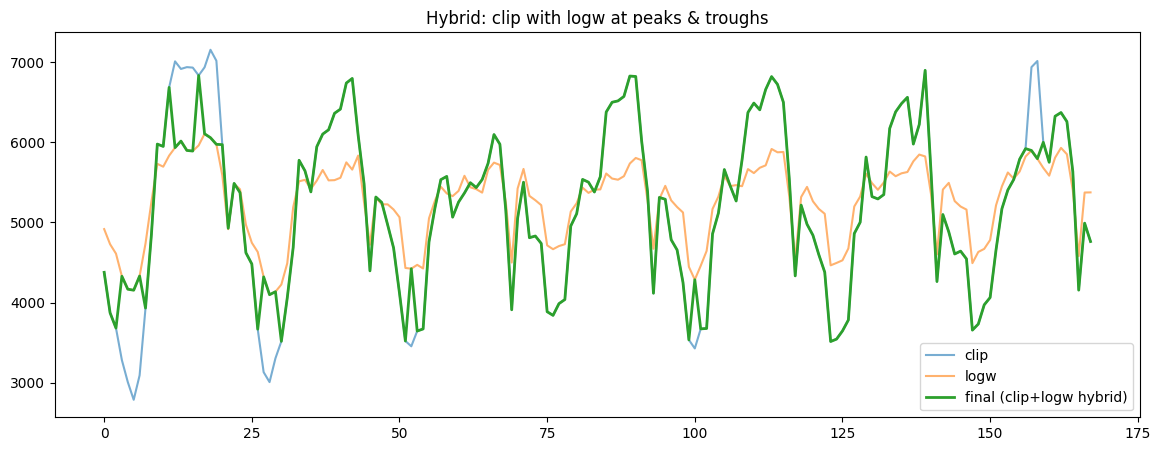

In [23]:
import pandas as pd
import numpy as np

# m: logw/clip/ens 병합된 DataFrame (앞에서 만든 것)
df = m.copy()

# --- 고점/저점 기준 설정
q_low, q_high = df["clip"].quantile([0.05, 0.95])
print("저점 기준:", q_low, " | 고점 기준:", q_high)

# --- 교체 로직
df["final"] = df["clip"]  # 기본은 clip
mask_replace = (df["clip"] <= q_low) | (df["clip"] >= q_high)
df.loc[mask_replace, "final"] = df.loc[mask_replace, "logw"]

print(f"대체된 포인트 수: {mask_replace.sum()} / {len(df)}")

# --- 확인용 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(df.index, df["clip"], label="clip", alpha=0.6)
plt.plot(df.index, df["logw"], label="logw", alpha=0.6)
plt.plot(df.index, df["final"], label="final (clip+logw hybrid)", linewidth=2)
plt.legend(); plt.title("Hybrid: clip with logw at peaks & troughs")
plt.show()


Local maxima/minima 개수: 26 + 28
총 교체된 지점 수: 54


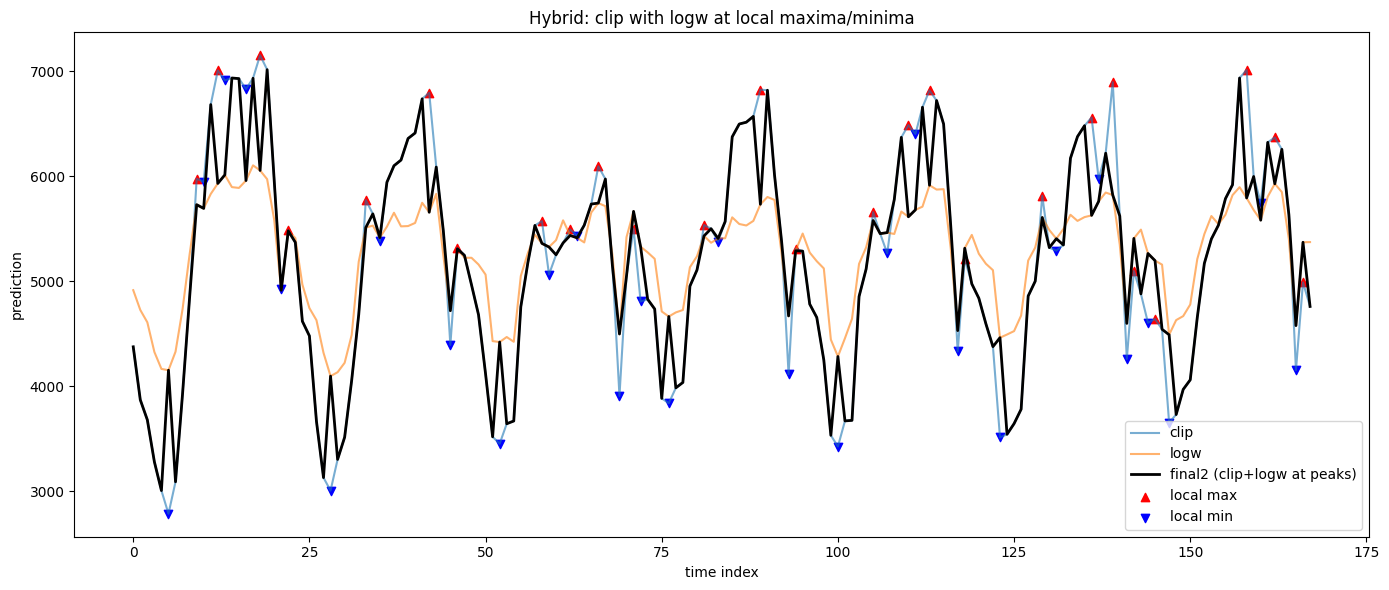

In [24]:
from scipy.signal import find_peaks

# m: logw/clip/ens 병합된 DataFrame (앞에서 만든 것)
df = df.copy()

# --- local maxima (고점)
peaks, _ = find_peaks(df["clip"].values, distance=3)   # distance=3 → 최소 간격(조정 가능)
# --- local minima (저점) : clip의 음수로 뒤집어서 찾음
troughs, _ = find_peaks(-df["clip"].values, distance=3)

# --- 교체 마스크 만들기
mask_replace = np.zeros(len(df), dtype=bool)
mask_replace[peaks] = True
mask_replace[troughs] = True

# --- clip 기반 hybrid 생성
df["final2"] = df["clip"].copy()
df.loc[mask_replace, "final2"] = df.loc[mask_replace, "logw"]

print(f"Local maxima/minima 개수: {len(peaks)} + {len(troughs)}")
print(f"총 교체된 지점 수: {mask_replace.sum()}")

# --- 시각화
plt.figure(figsize=(14,6))
plt.plot(df.index, df["clip"], label="clip", alpha=0.6)
plt.plot(df.index, df["logw"], label="logw", alpha=0.6)
plt.plot(df.index, df["final2"], label="final2 (clip+logw at peaks)", linewidth=2, color="black")

# 고점/저점 위치 표시
plt.scatter(peaks, df["clip"].iloc[peaks], color="red", marker="^", label="local max")
plt.scatter(troughs, df["clip"].iloc[troughs], color="blue", marker="v", label="local min")

plt.legend()
plt.title("Hybrid: clip with logw at local maxima/minima")
plt.xlabel("time index")
plt.ylabel("prediction")
plt.tight_layout()
plt.show()


In [26]:
df['answer'] = (df['final']+df['final2'])/2
df

,num_date_time,logw,clip,ens,final,final2,answer
0,1_20240825 00,4916.669678,4377.2407,4505.021843,4377.240700,4377.240700,4377.240700
1,1_20240825 01,4728.371338,3872.5774,4357.705858,3872.577400,3872.577400,3872.577400
2,1_20240825 02,4610.544189,3681.8218,3993.383442,3681.821800,3681.821800,3681.821800
3,1_20240825 03,4328.175293,3282.3052,3459.373699,4328.175293,3282.305200,3805.240247
4,1_20240825 04,4166.913086,3008.5354,3291.703116,4166.913086,3008.535400,3587.724243
...,...,...,...,...,...,...,...
163,1_20240831 19,5850.649902,6257.7324,6239.785942,6257.732400,6257.732400,6257.732400
164,1_20240831 20,5400.094727,5633.9530,5389.450955,5633.953000,5633.953000,5633.953000
165,1_20240831 21,4579.540771,4155.2640,4524.814966,4155.264000,4579.540771,4367.402385
166,1_20240831 22,5372.835449,4990.6160,5025.554166,4990.616000,5372.835449,5181.725725


In [27]:
df[['num_date_time','answer']].to_csv('Submit/submit0823_ensemble_mean')

,num_date_time,answer
0,1_20240825 00,4377.240700
1,1_20240825 01,3872.577400
2,1_20240825 02,3681.821800
3,1_20240825 03,3805.240247
4,1_20240825 04,3587.724243
...,...,...
163,1_20240831 19,6257.732400
164,1_20240831 20,5633.953000
165,1_20240831 21,4367.402385
166,1_20240831 22,5181.725725


In [17]:
df

,num_date_time,logw,clip,ens,final
0,1_20240825 00,4916.669678,4377.2407,4505.021843,4377.240700
1,1_20240825 01,4728.371338,3872.5774,4357.705858,3872.577400
2,1_20240825 02,4610.544189,3681.8218,3993.383442,3681.821800
3,1_20240825 03,4328.175293,3282.3052,3459.373699,3282.305200
4,1_20240825 04,4166.913086,3008.5354,3291.703116,3008.535400
...,...,...,...,...,...
163,1_20240831 19,5850.649902,6257.7324,6239.785942,6257.732400
164,1_20240831 20,5400.094727,5633.9530,5389.450955,5633.953000
165,1_20240831 21,4579.540771,4155.2640,4524.814966,4579.540771
166,1_20240831 22,5372.835449,4990.6160,5025.554166,5372.835449


In [33]:
import pandas as pd
import numpy as np

# ===== 경로 =====
SAMPLE_PATH = "Data/sample_submission.csv"
OUT_PATH    = "Submit/submission_hybrid_peaks_per_building.csv"

# ===== 이미 로드된 제출 데이터프레임 사용 =====
# logw_df = pd.read_csv('Submit/submission_xgb_logw_final.csv')
# clip_df = pd.read_csv('Submit/submit_0822_clipped3.66.csv')
# ensenble_df = pd.read_csv('Submit/submit0821_가중앙상블+클리핑3.3732.csv')  # 선택

def std(df, name):
    c = "answer" if "answer" in df.columns else ("pred" if "pred" in df.columns else None)
    if c is None: raise ValueError(f"{name}: 예측 컬럼 필요(answer/pred).")
    out = df[["num_date_time", c]].copy()
    out["num_date_time"] = out["num_date_time"].astype(str)
    out[c] = pd.to_numeric(out[c], errors="coerce")
    return out.rename(columns={c: name})

logw = std(logw_df, "logw")
clip = std(clip_df, "clip")

# 샘플 키 기준으로 병합(순서 고정)
sample = pd.read_csv(SAMPLE_PATH, dtype={"num_date_time": str})[["num_date_time"]]
m = (sample
     .merge(clip, on="num_date_time", how="left")
     .merge(logw, on="num_date_time", how="left"))

# 빌딩/시간 파싱
m["building"] = m["num_date_time"].str.split("_").str[0]
m["_t"] = pd.to_datetime(m["num_date_time"].str.split("_").str[-1],
                         format="%Y%m%d %H", errors="coerce")

# --- 로컬 극값 탐지(양끝 제외) ---
def local_extrema_mask(values, min_gap=1):
    """
    v[i-1] < v[i] > v[i+1] (peak) 또는 v[i-1] > v[i] < v[i+1] (trough)
    min_gap>=1이면 너무 촘촘한 극값을 일부 억제(간단한 NMS 역할)
    """
    v = np.asarray(values, dtype=float)
    n = len(v)
    if n < 3:
        return np.zeros(n, dtype=bool)
    left  = v[1:-1] - v[:-2]
    right = v[1:-1] - v[2:]
    is_peak   = (left > 0) & (right > 0)
    is_trough = (left < 0) & (right < 0)
    mask = np.zeros(n, dtype=bool)
    mask[1:-1] = is_peak | is_trough

    if min_gap <= 1:  # 조밀 억제 비활성
        return mask

    # 간단한 간격 억제: True 인덱스들 중 min_gap 미만으로 붙어 있으면 하나만 유지
    idx = np.where(mask)[0]
    keep = []
    last = -10**9
    for i in idx:
        if i - last >= min_gap:
            keep.append(i)
            last = i
    mask[:] = False
    mask[np.array(keep, dtype=int)] = True
    return mask

# --- 건물별로 피크/바닥만 logw로 대체 ---
def hybrid_per_building(g: pd.DataFrame, min_gap=3):
    # 시간 순 정렬
    g = g.sort_values("_t").copy()

    # 기본은 clip
    g["hyb"] = g["clip"]

    # clip이 있는 곳만 대상으로 극값 탐지
    idx_valid = g["clip"].notna().values
    if idx_valid.sum() >= 3:
        # 전체 길이 기준 마스크 계산(clip 값이 NaN이면 자동 False 취급)
        mask_local = local_extrema_mask(g["clip"].values, min_gap=min_gap)

        # 대체값: logw가 NaN이면 clip 유지(불필요한 NaN 전파 방지)
        rep_vals = g["logw"].where(g["logw"].notna(), g["clip"])
        g.loc[mask_local, "hyb"] = rep_vals[mask_local]

    return g[["num_date_time", "hyb"]]

parts = []
for _, g in m.groupby("building", dropna=False):
    parts.append(hybrid_per_building(g, min_gap=3))

hyb = pd.concat(parts, ignore_index=True)
hyb

,num_date_time,hyb
0,1_20240825 00,4377.240700
1,1_20240825 01,3872.577400
2,1_20240825 02,3681.821800
3,1_20240825 03,3282.305200
4,1_20240825 04,3008.535400
...,...,...
16795,99_20240831 19,1218.320900
16796,99_20240831 20,1174.477234
16797,99_20240831 21,1266.396200
16798,99_20240831 22,1196.279900


In [34]:
# 제출 생성(샘플 순서 유지)
submit = sample.merge(hyb, on="num_date_time", how="left")
submit["answer"] = (pd.to_numeric(submit["hyb"], errors="coerce")
                      .fillna(0.0)
                      .clip(lower=0)
                      .round(4))
submit = submit[["num_date_time", "answer"]]
submit.to_csv(OUT_PATH, index=False)
print(f"[OK] 저장: {OUT_PATH} | rows={len(submit)}")


[OK] 저장: Submit/submission_hybrid_peaks_per_building.csv | rows=16800


In [36]:
import pandas as pd
import numpy as np

# ===== 경로 =====
SAMPLE_PATH = "Data/sample_submission.csv"          # 샘플 제출 (순서/키 기준)
LOGW_PATH   = "Submit/submission_xgb_logw_final.csv"  # logw 제출
CLIP_PATH   = "Submit/submit_0822_clipped3.66.csv"    # clip 제출
OUT_PATH    = "Submit/submission_hybrid_all.csv"      # 출력 파일명

# ===== 로드 =====
logw_df = pd.read_csv(LOGW_PATH, dtype={"num_date_time": str})
clip_df = pd.read_csv(CLIP_PATH, dtype={"num_date_time": str})
sample  = pd.read_csv(SAMPLE_PATH, dtype={"num_date_time": str})[["num_date_time"]]

def std(df, name):
    # answer/pred 중 하나를 예측 컬럼으로 인식
    val_col = "answer" if "answer" in df.columns else ("pred" if "pred" in df.columns else None)
    if val_col is None:
        raise ValueError(f"{name}: 예측 컬럼(answer/pred)이 없습니다.")
    out = df[["num_date_time", val_col]].copy()
    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    return out.rename(columns={val_col: name})

logw = std(logw_df, "logw")
clip = std(clip_df, "clip")

# 샘플 키 기준 병합(순서 고정)
m = (sample
     .merge(clip, on="num_date_time", how="left")
     .merge(logw, on="num_date_time", how="left"))

# 빌딩/시간 파싱(정렬/그룹 도우미)
m["building"] = m["num_date_time"].str.split("_").str[0]
m["_t"] = pd.to_datetime(
    m["num_date_time"].str.split("_").str[-1],
    format="%Y%m%d %H", errors="coerce"
)

# ===== 분위수 기반 하이브리드 =====
def hybrid_quantile(group: pd.DataFrame, q_low=0.05, q_high=0.95) -> pd.DataFrame:
    g = group.sort_values("_t").copy()

    # 기본은 clip
    g["hyb"] = g["clip"]

    # clip 값이 있는 시점만으로 분위 계산
    mask_nn = g["clip"].notna()
    if mask_nn.any():
        ql, qh = g.loc[mask_nn, "clip"].quantile([q_low, q_high])
        mask_replace = mask_nn & ((g["clip"] <= ql) | (g["clip"] >= qh))
        # logw가 NaN이면 clip 유지 (안전)
        g.loc[mask_replace, "hyb"] = g.loc[mask_replace, "logw"].where(
            g.loc[mask_replace, "logw"].notna(),
            g.loc[mask_replace, "clip"]
        )

    return g[["num_date_time", "hyb"]]

parts = []
for _, g in m.groupby("building", dropna=False):
    parts.append(hybrid_quantile(g, q_low=0.05, q_high=0.95))  # 분위 조정 가능

hyb_all = pd.concat(parts, ignore_index=True)

# 제출 만들기 (샘플 순서)
submit = sample.merge(hyb_all, on="num_date_time", how="left")
submit["answer"] = (pd.to_numeric(submit["hyb"], errors="coerce")
                      .fillna(0.0)
                      .clip(lower=0)
                      .round(6))
submit = submit[["num_date_time", "answer"]]

# 저장
submit.to_csv(OUT_PATH, index=False)
print(f"[OK] 저장: {OUT_PATH} | rows={len(submit)}")


[OK] 저장: Submit/submission_hybrid_all.csv | rows=16800


In [37]:
# 두 결과 불러오기
quantile_sub = pd.read_csv("Submit/submission_hybrid_all.csv")               # 분위수 기반
peak_sub     = pd.read_csv("Submit/submission_hybrid_peaks_per_building.csv") # 피크 기반

# num_date_time 키 기준 병합
comp = quantile_sub.merge(peak_sub, on="num_date_time", suffixes=("_quant", "_peak"))

# 차이 계산
comp["diff"] = comp["answer_peak"] - comp["answer_quant"]

# 차이 요약
print("=== 차이 통계 ===")
print(comp["diff"].describe())

# 실제 차이 존재 여부
n_diff = (comp["diff"].abs() > 1e-8).sum()
print(f"총 {n_diff}개 row에서 값이 다름")

# 샘플 몇 개 확인
print("\n=== 차이 예시 10개 ===")
print(comp.loc[comp["diff"].abs() > 1e-8].head(10))


=== 차이 통계 ===
count    16800.000000
mean        -5.658856
std        201.955881
min      -3462.674973
25%          0.000000
50%          0.000000
75%          0.000000
max       3476.626500
Name: diff, dtype: float64
총 4952개 row에서 값이 다름

=== 차이 예시 10개 ===
    num_date_time  answer_quant  answer_peak         diff
3   1_20240825 03   4328.175293    3282.3052 -1045.870093
4   1_20240825 04   4166.913086    3008.5354 -1158.377686
5   1_20240825 05   4154.371216    4154.3712    -0.000016
6   1_20240825 06   4330.874023    3092.0260 -1238.848023
9   1_20240825 09   5976.987300    5730.7864  -246.200900
12  1_20240825 12   5932.849854    5932.8499     0.000046
13  1_20240825 13   6014.492920    6914.4785   899.985580
14  1_20240825 14   5898.012695    6937.0320  1039.019305
15  1_20240825 15   5890.172119    6931.0586  1040.886481
16  1_20240825 16   6832.893600    5960.4495  -872.444100


In [39]:
import pandas as pd
import numpy as np

SAMPLE_PATH = "Data/sample_submission.csv"
OUT_PATH    = "Submit/submission_hybrid_peaks_per_building_amplified.csv"

def std(df, name):
    c = "answer" if "answer" in df.columns else ("pred" if "pred" in df.columns else None)
    out = df[["num_date_time", c]].copy()
    out["num_date_time"] = out["num_date_time"].astype(str)
    out[c] = pd.to_numeric(out[c], errors="coerce")
    return out.rename(columns={c: name})

# 이미 읽어둔 데이터프레임 사용
# logw_df = pd.read_csv(...)
# clip_df = pd.read_csv(...)

logw   = std(logw_df, "logw")
clip   = std(clip_df, "clip")
sample = pd.read_csv(SAMPLE_PATH, dtype={"num_date_time": str})[["num_date_time"]]

m = (sample.merge(clip, on="num_date_time", how="left")
           .merge(logw, on="num_date_time", how="left"))
m["building"] = m["num_date_time"].str.split("_").str[0]
m["_t"] = pd.to_datetime(m["num_date_time"].str.split("_").str[-1], format="%Y%m%d %H", errors="coerce")

def local_extrema_mask(v: np.ndarray, min_gap=3):
    v = np.asarray(v, dtype=float)
    n = len(v)
    if n < 3: return np.zeros(n, dtype=bool)
    left  = v[1:-1] - v[:-2]
    right = v[1:-1] - v[2:]
    mask = np.zeros(n, dtype=bool)
    mask[1:-1] = ((left > 0) & (right > 0)) | ((left < 0) & (right < 0))
    if min_gap <= 1: return mask
    idx = np.where(mask)[0]
    keep, last = [], -10**9
    for i in idx:
        if i - last >= min_gap:
            keep.append(i); last = i
    mask[:] = False
    mask[np.array(keep, int)] = True
    return mask

def hybrid_amplified_per_building(g: pd.DataFrame, beta=1.5, min_gap=3, clip_lower=0.0):
    g = g.sort_values("_t").copy()
    g["hyb"] = g["clip"]  # 기본은 clip
    if g["clip"].notna().sum() >= 3:
        mask_local = local_extrema_mask(g["clip"].values, min_gap=min_gap)
        # 대체값: logw 없으면 clip 사용(NaN 방지)
        rep = g["logw"].where(g["logw"].notna(), g["clip"])
        # 증폭: clip + beta*(logw-clip), beta>1이면 logw보다 더 멀리
        g.loc[mask_local, "hyb"] = (g.loc[mask_local, "clip"] + beta * (rep[mask_local] - g.loc[mask_local, "clip"]))
    # 안전 클리핑(원하면 제거)
    if clip_lower is not None:
        g["hyb"] = g["hyb"].clip(lower=clip_lower)
    return g[["num_date_time", "hyb"]]

parts = []
for _, gb in m.groupby("building", dropna=False):
    parts.append(hybrid_amplified_per_building(gb, beta=1.5, min_gap=3))

hyb = pd.concat(parts, ignore_index=True)
submit = sample.merge(hyb, on="num_date_time", how="left")
submit["answer"] = (pd.to_numeric(submit["hyb"], errors="coerce").fillna(0.0).clip(lower=0).round(6))
submit = submit[["num_date_time", "answer"]]
submit.to_csv(OUT_PATH, index=False)
print(f"[OK] 저장: {OUT_PATH} | rows={len(submit)} | beta=1.5")


[OK] 저장: Submit/submission_hybrid_peaks_per_building_amplified.csv | rows=16800 | beta=1.5


=== 차이 통계 ===
count    16800.000000
mean        -9.884148
std         94.748800
min      -1751.171895
25%          0.000000
50%          0.000000
75%          0.000000
max       1738.313247
Name: diff, dtype: float64
총 3992개 row에서 값이 다름


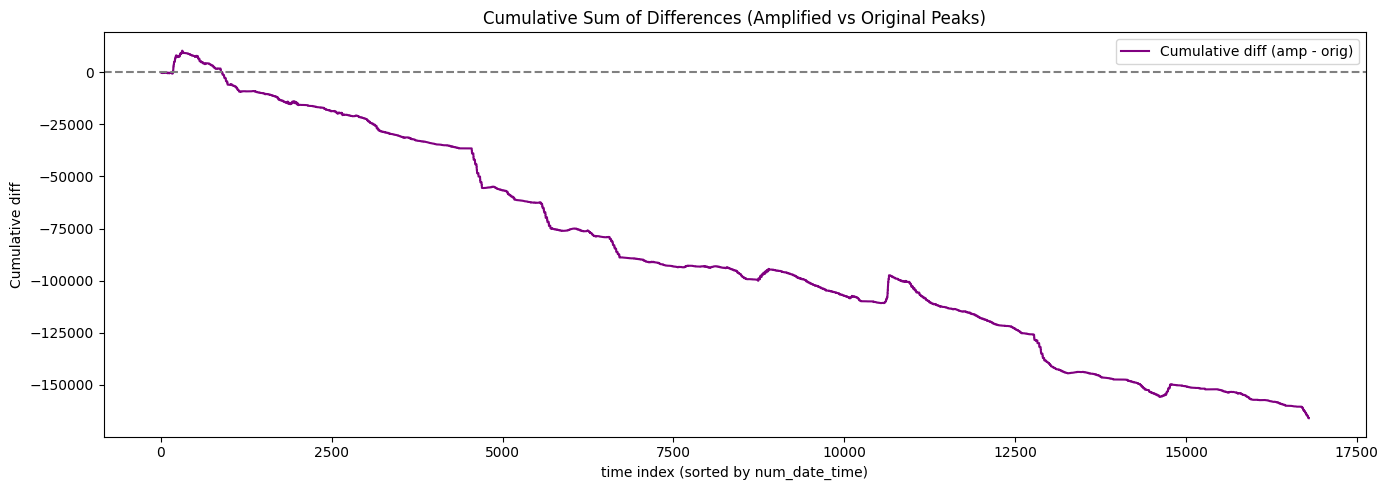

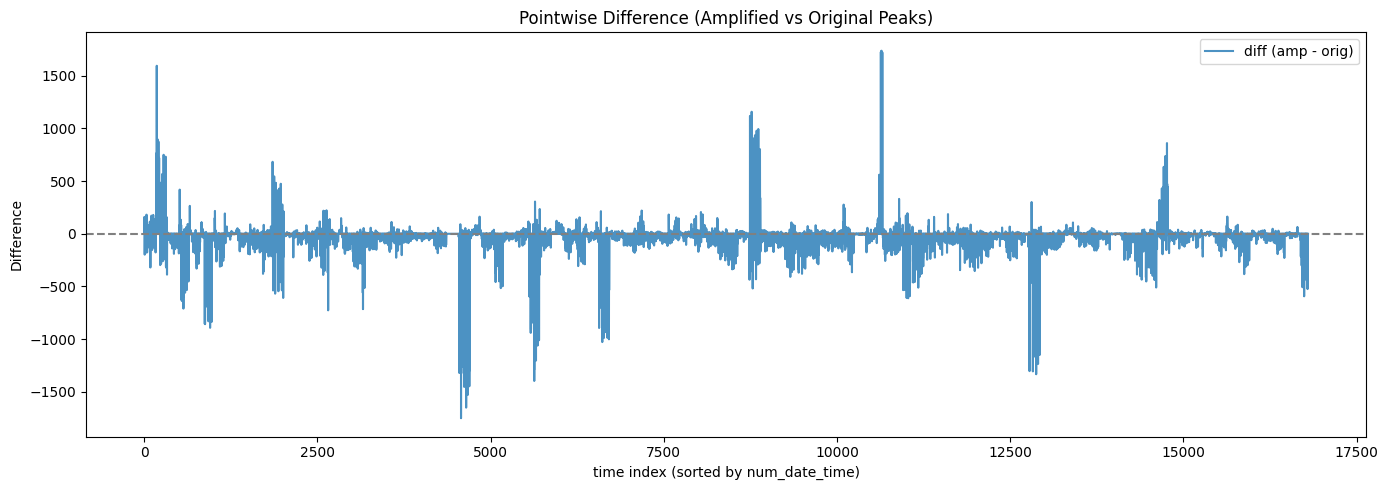

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== 기존 vs 증폭 결과 로드 =====
orig_path = "Submit/submission_hybrid_peaks_per_building.csv"
amp_path  = "Submit/submission_hybrid_peaks_per_building_amplified.csv"

orig = pd.read_csv(orig_path, dtype={"num_date_time": str})
amp  = pd.read_csv(amp_path, dtype={"num_date_time": str})

comp = orig.merge(amp, on="num_date_time", suffixes=("_orig", "_amp"))
comp["diff"] = comp["answer_amp"] - comp["answer_orig"]

# ===== 차이 통계 =====
print("=== 차이 통계 ===")
print(comp["diff"].describe())
print(f"총 { (comp['diff'].abs() > 1e-8).sum() }개 row에서 값이 다름")

# ===== 누적합 (cumulative sum) =====
comp = comp.sort_values("num_date_time").reset_index(drop=True)
comp["cumsum_diff"] = comp["diff"].cumsum()

plt.figure(figsize=(14,5))
plt.plot(comp.index, comp["cumsum_diff"], label="Cumulative diff (amp - orig)", color="purple")
plt.axhline(0, ls="--", color="gray")
plt.title("Cumulative Sum of Differences (Amplified vs Original Peaks)")
plt.xlabel("time index (sorted by num_date_time)")
plt.ylabel("Cumulative diff")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 라인플롯 (차이 시계열) =====
plt.figure(figsize=(14,5))
plt.plot(comp.index, comp["diff"], label="diff (amp - orig)", alpha=0.8)
plt.axhline(0, ls="--", color="gray")
plt.title("Pointwise Difference (Amplified vs Original Peaks)")
plt.xlabel("time index (sorted by num_date_time)")
plt.ylabel("Difference")
plt.legend()
plt.tight_layout()
plt.show()
